# LANGUAGE MODELING WITH LSTM

<center>This project is an NLP project for word prediction, the model will predict the next work in a sentence. The data set is the Penn Treebank data set which contains lots correct English sentences. The data set contains training, testing and validation set, which we are going to use the training set for training and the testing set for validation. We will divide the data set into 20 word per sentence, i.e each sequence will contain 20 time steps. So we go over the training and analyze the training performance and  the validation performance. we will be using tensorflow library<center>

In [1]:
!pip install altair

In [2]:
import time
import numpy as np
import tensorflow as tf
print(tf.__version__ )

2.11.0


In [3]:
# importing neccessary packages
import matplotlib.pyplot as plt
import collections
import os

import numpy as np
import tensorflow as tf

Writting a function to get our data set from the directory, the function will return a list which contains every sentence in numbers, i.e each word is represented with a number which is its index and a dictionary which contains each word as key and index as value

In [4]:
def get_data(filename):
    #define the directory to get our data set
    file_path = os.path.join(data_dir, filename)
    #read our data from the directory and replace every new line with <eos>, (end of sentence)
    with tf.io.gfile.GFile(file_path, "r") as f:
        file=f.read().replace("\n", "<eos>").split()
        
    word_to_id_path= os.path.join(data_dir, 'ptb.train.txt')
    with tf.io.gfile.GFile(word_to_id_path, "r") as f:
        word_to_id_file=f.read().replace("\n", "<eos>").split()
        
    #arrang each word in our data set according to their indexes
    counter = collections.Counter(word_to_id_file)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, count = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    sen_no= [word_to_id[word] for word in file if word in word_to_id]
    
    return sen_no, word_to_id


we can now get our data set according to the indexes of each word and every sentence in the data set represented in numbers.

In [82]:
data_dir = "data/simple-examples/data/"

#train data set
train_sen_no, word_to_id = get_data('ptb.train.txt')
#validation data set
va_sen_no, word_to_id = get_data('ptb.valid.txt')
#testing set
test_va_sen_no, word_to_id = get_data('ptb.test.txt')
#get lenght of the word id 
len(word_to_id), len(train_sen_no)

(10000, 929589)

write a function to transform the sentence to words from numbers

In [6]:
def id_to_word(vocab, id_list):
    line = []
    for w in id_list:
        for word, wid in vocab.items():
            if wid == w:
                line.append(word)
    return line            
                

In [7]:
# the first 100 words
words_no=train_sen_no[0:100]
#print the first 100 words
print(np.reshape(words_no, (1, -1)))

[[9970 9971 9972 9974 9975 9976 9980 9981 9982 9983 9984 9986 9987 9988
  9989 9991 9992 9993 9994 9995 9996 9997 9998 9999    2 9256    1    3
    72  393   33 2133    0  146   19    6 9207  276  407    3    2   23
     1   13  141    4    1 5465    0 3081 1596   96    2 7682    1    3
    72  393    8  337  141    4 2477  657 2170  955   24  521    6 9207
   276    4   39  303  438 3684    2    6  942    4 3150  496  263    5
   138 6092 4241 6036   30  988    6  241  760    4 1015 2786  211    6
    96    4]]


In [8]:
# getting the it in alphabetic form
np.reshape(id_to_word(word_to_id, words_no), (1,-1))

array([['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett',
        'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia',
        'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens',
        'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>',
        'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the',
        'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N',
        '<eos>', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.',
        'the', 'dutch', 'publishing', 'group', '<eos>', 'rudolph',
        '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of',
        'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a',
        'nonexecutive', 'director', 'of', 'this', 'british',
        'industrial', 'conglomerate', '<eos>', 'a', 'form', 'of',
        'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette',
        'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of',
        'cancer', 'de

define a function to get an itrator for our data set. the function will return an itrator which contains our data set in batch size and time step

In [9]:
def loader(file, batch_size,num_steps):
    raw_data = np.array(file, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]
        
    epoch_size = (batch_len - 1) // num_steps
    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        
        yield(x, y)

In [10]:
# using our itrator loader to get  generrate our data set in 30 batches and 20 time steps
train_itter=loader(train_sen_no,30, 20)


In [11]:
test_itter=loader(test_va_sen_no, 30, 30)

In [12]:
# get the first training batch
first_touple = train_itter.__next__()
features = first_touple[0]
targets = first_touple[1]

In [13]:
targets.shape

(30, 20)

Defining embedding layer for our model. each word will have 200 embedding vectors

In [14]:
batch_size=30
num_steps=20
emddind_size=1000
# set device to cpu since we dont have gpu
with tf.device("/cpu:0"):
    embedding = tf.keras.layers.Embedding(len(word_to_id),emddind_size ,batch_input_shape=(batch_size, num_steps),trainable=True,name="embedding_vocab")
#pass the first batch to the embedding layer 
model_input=embedding(features)

In [15]:
# get the shape of the output of the embedding layer
model_input.shape

TensorShape([30, 20, 1000])

Defining the LSTM cells and stacking them to build our model

In [16]:
lstm_cell_l1 = tf.keras.layers.LSTMCell(250)
lstm_cell_l2 = tf.keras.layers.LSTMCell(128)
stacked_lstm = tf.keras.layers.StackedRNNCells([lstm_cell_l1, lstm_cell_l2])
layer  =  tf.keras.layers.RNN(stacked_lstm,[30, 20],return_state=False,stateful=True,trainable=True)

In [17]:
#initializing our rnn  initial state to zeros
init_state = tf.Variable(tf.zeros([30,1000]),trainable=False)
layer.inital_state = init_state

Input the output of our embedding layer to our RNN layer

In [18]:
# pass the ouput of embedding layer to RNN layer
rnn_out_put=layer(model_input)
rnn_out_put.shape

TensorShape([30, 20, 128])

build fully connected layer and the output is 1000 which represents each word in the word id

In [19]:
#define dense layer
dense = tf.keras.layers.Dense(10000)

In [20]:
#pass the output of the RNN layer to the fully connected layer
densed_output=dense(rnn_out_put)
densed_output.shape

TensorShape([30, 20, 10000])

In [21]:
#define a sofmax function
activation = tf.keras.layers.Activation('softmax')

In [22]:
# pass the output of the fully connected layer to get the probability of each word
prob= activation(densed_output)
prob.shape

TensorShape([30, 20, 10000])

In [23]:
#use argmax function to get the predicted words for the third sequence
yhat=np.argmax(prob[3,0:20], axis=1)
yhat

array([7146, 7102, 6733, 7642, 7642, 8040, 4958, 4470, 4470, 4470, 1215,
       1215, 1215, 7946, 7946, 8773, 8773, 8773, 8773,  104], dtype=int64)

In [24]:
# get the predicted words in alpherbets
np.reshape(id_to_word(word_to_id, yhat), (1,-1))

array([['slack', 'reminder', 'adult', 'pros', 'pros', 'eighth',
        'perestroika', 'entrepreneur', 'entrepreneur', 'entrepreneur',
        'add', 'add', 'add', 'commit', 'commit', 'conceptual',
        'conceptual', 'conceptual', 'conceptual', 'bank']], dtype='<U12')

In [25]:
# get the actual word
np.reshape(id_to_word(word_to_id, targets[3]), (1,-1))

array([['shares', 'of', 'its', 'common', 'stock', 'for', 'each', 'of',
        '<unk>', 'deposit', "'s", 'N', 'shares', 'outstanding', '<eos>',
        'liberty', 'national', 'a', 'bank', 'holding']], dtype='<U11')

In [26]:
#define a function to calculate our crossentropy loss
def crossentropy(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

In [27]:
targets.shape, prob.shape

((30, 20), TensorShape([30, 20, 10000]))

In [28]:
# calculate the loss of our model output with respect to the actual value
loss=crossentropy(targets, prob)
loss.shape

TensorShape([30, 20])

In [29]:
#calculate the average loss of our prediction
cost = tf.reduce_sum(loss) / batch_size
cost

<tf.Tensor: shape=(), dtype=float32, numpy=184.20639>

In [30]:
# define a variable for our learning rate
lr = tf.Variable(0.0, trainable=False)
# set our optimizer (gradient decent)
optimizer = tf.keras.optimizers.SGD(lr=lr, clipnorm=5)

In [31]:
print(optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>


we can now build our model

In [32]:
model=tf.keras.Sequential()
model.add(embedding)
model.add(layer)
model.add(dense)
model.add(activation)
model.compile(loss=crossentropy, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_vocab (Embedding)  (30, 20, 1000)           10000000  
                                                                 
 rnn (RNN)                   (30, 20, 128)             1475048   
                                                                 
 dense (Dense)               (30, 20, 10000)           1290000   
                                                                 
 activation (Activation)     (30, 20, 10000)           0         
                                                                 
Total params: 12,765,048
Trainable params: 12,735,048
Non-trainable params: 30,000
_________________________________________________________________


In [33]:
# checking if the learning rate was properly set
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [34]:
# testing our model by passing the first batch along with the time taken in second
start=time.time()
yhat=model(features)
finish=time.time()
total=finish-start
print(total, yhat.shape)

0.3838200569152832 (30, 20, 10000)


In [35]:
#inspecting our tainable paremeters
tvars = model.trainable_variables
for i in tvars:
    print(i.name, i.shape)

embedding_vocab/embeddings:0 (10000, 1000)
rnn/stacked_rnn_cells/lstm_cell/kernel:0 (1000, 1000)
rnn/stacked_rnn_cells/lstm_cell/recurrent_kernel:0 (250, 1000)
rnn/stacked_rnn_cells/lstm_cell/bias:0 (1000,)
rnn/stacked_rnn_cells/lstm_cell_1/kernel:0 (250, 512)
rnn/stacked_rnn_cells/lstm_cell_1/recurrent_kernel:0 (128, 512)
rnn/stacked_rnn_cells/lstm_cell_1/bias:0 (512,)
dense/kernel:0 (128, 10000)
dense/bias:0 (10000,)


<b>Training phase. </b> defining a function the train our training set and analyzing the the training loss and the perplexity. In the training phase, the learning rate was set to decay when a particular threshold is reached and we also applied max_grad_norm to clip our gradients to avoid exploding gradients problems

In [36]:
train_epoc_cost_list=[]
train_perplexity_list=[]
def train(epoc_size):
    
    
    # epoc itration
    for i in range(epoc_size):
        print('epoc {} begins'.format(i+1))
        epoc_cost_list=[]
        perplexity_list=[]
        train_itter=loader(train_sen_no,30, 20)
        #define decay condtion
        if epoc_size >= max_epoch_decay_lr:
            lr_decay = decay ** max(i - max_epoch_decay_lr, 0.0)
            dcr = learning_rate * lr_decay
            K.set_value(model.optimizer.learning_rate,dcr)
        learning_r= model.optimizer.learning_rate
        print('epoc {} learning rate is {}'.format(i+1, learning_r))
        epoc_cost=0
        itter=0
        couter=0
        # batch training
        for batch in train_itter:
            x=batch[0]
            y=batch[1]
            with tf.GradientTape() as tape:
                prob = model(x)
                loss  = crossentropy(y, prob)
                cost = tf.reduce_sum(loss,axis=0) / batch_size
                batch_cost= tf.reduce_sum(loss) / batch_size
                
            #calculate gradient
            grad_t_list = tape.gradient(cost, tvars)
            #clip gradients
            grads, _ = tf.clip_by_global_norm(grad_t_list, max_grad_norm)
            #update our parameters with respect to gradient
            train_op = optimizer.apply_gradients(zip(grads, tvars))
            #append train loss
            train_epoc_cost_list.append(batch_cost)
            epoc_cost_list.append(batch_cost)
            # count loss
            epoc_cost+=batch_cost
            itter+=step_size
            #calculate perplexity
            perplexity= np.exp(epoc_cost/itter)
            perplexity_list.append(perplexity)
            train_perplexity_list.append(perplexity)
            
            #print perplexity for every 500 batches
            if couter % 500==0:
                print('perplexity is {}'.format(perplexity))
            couter+=1
        print('epoc {} completed'.format(i+1))
        print('epoc {} final perplexity is {}'.format(i+1, perplexity))
         
            #vizualize a plot of out training loss and perplexity for every epoc
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[ 0].plot(np.array(epoc_cost_list))
        axes[ 0].set_title('epoc cost')
        axes[ 0].set_xlabel('batches')
        axes[ 0].set_ylabel('cost')
        axes[ 0].grid(True)
        
        axes[ 1].plot(np.array(perplexity_list))
        axes[ 1].set_title('perplexity plot')
        axes[ 1].set_xlabel('batches')
        axes[ 1].set_ylabel('perplexity')
        axes[ 1].grid(True)
            
            
        plt.tight_layout()
        plt.show()
        
  

### Train the model with 10 epocs and learning rate of 1.0 which learning rate will start decaying at max epoc of 7

epoc 1 begins
epoc 1 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 9999.8203125
perplexity is 627.2117309570312
perplexity is 417.418212890625
perplexity is 336.0303955078125
epoc 1 completed
epoc 1 final perplexity is 331.1654357910156


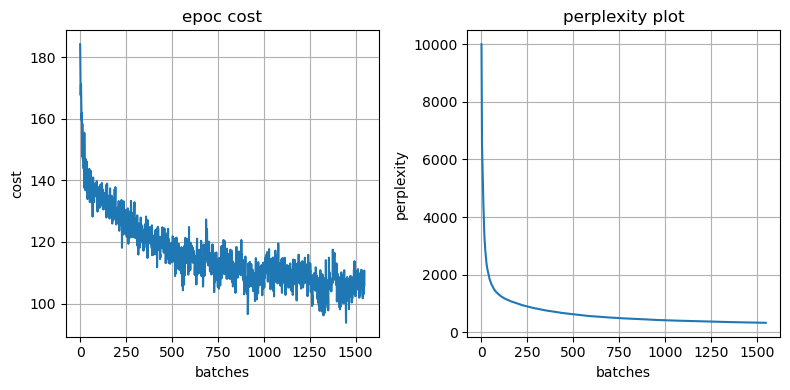

epoc 2 begins
epoc 2 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 281.2669372558594
perplexity is 182.3929443359375
perplexity is 165.4439697265625
perplexity is 156.28309631347656
epoc 2 completed
epoc 2 final perplexity is 155.92112731933594


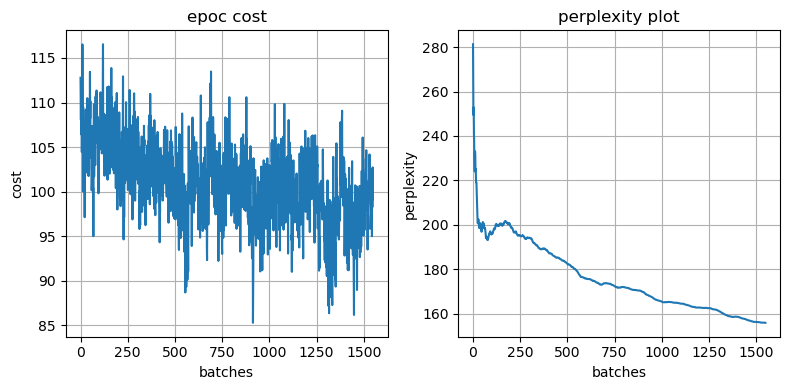

epoc 3 begins
epoc 3 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 223.4231719970703
perplexity is 130.73037719726562
perplexity is 122.39218139648438
perplexity is 118.17445373535156
epoc 3 completed
epoc 3 final perplexity is 118.13090515136719


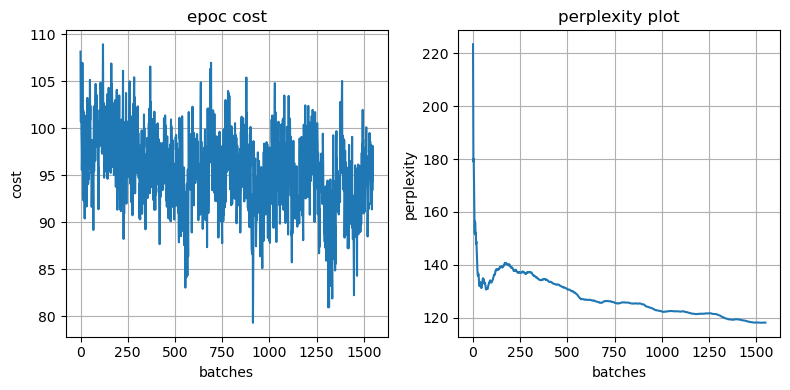

epoc 4 begins
epoc 4 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 197.82241821289062
perplexity is 107.232177734375
perplexity is 101.58988952636719
perplexity is 99.01903533935547
epoc 4 completed
epoc 4 final perplexity is 99.07283020019531


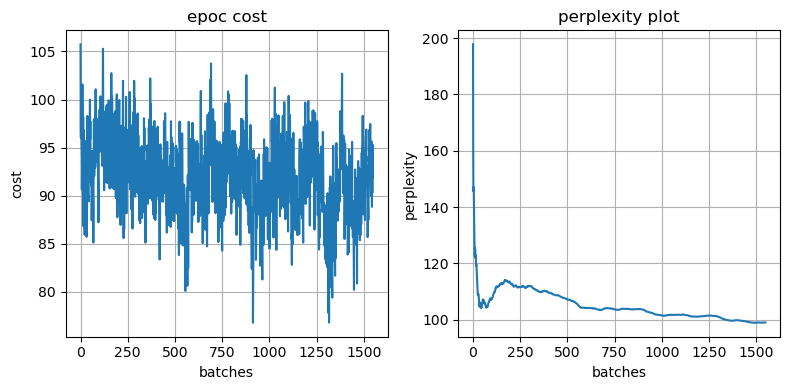

epoc 5 begins
epoc 5 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 172.12533569335938
perplexity is 93.0642318725586
perplexity is 88.73101806640625
perplexity is 86.88980102539062
epoc 5 completed
epoc 5 final perplexity is 86.94906616210938


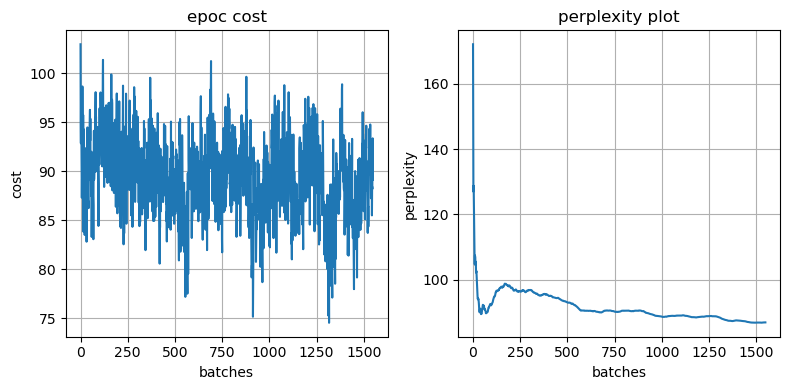

epoc 6 begins
epoc 6 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 157.0037384033203
perplexity is 82.9246597290039
perplexity is 79.40625
perplexity is 77.9405288696289
epoc 6 completed
epoc 6 final perplexity is 78.0118408203125


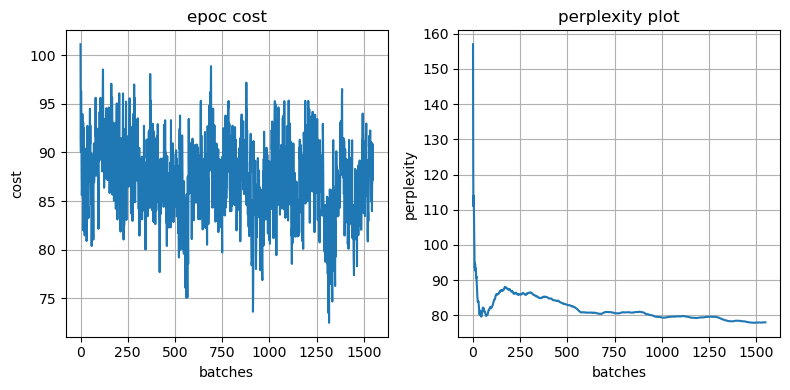

epoc 7 begins
epoc 7 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 146.60067749023438
perplexity is 75.35985565185547
perplexity is 72.33872985839844
perplexity is 71.14214324951172
epoc 7 completed
epoc 7 final perplexity is 71.22795104980469


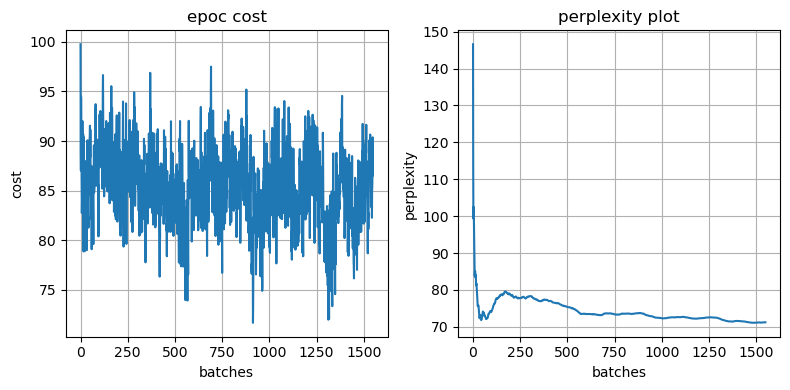

epoc 8 begins
epoc 8 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 139.50146484375
perplexity is 69.5260238647461
perplexity is 66.88031768798828
perplexity is 65.93875885009766
epoc 8 completed
epoc 8 final perplexity is 66.04061889648438


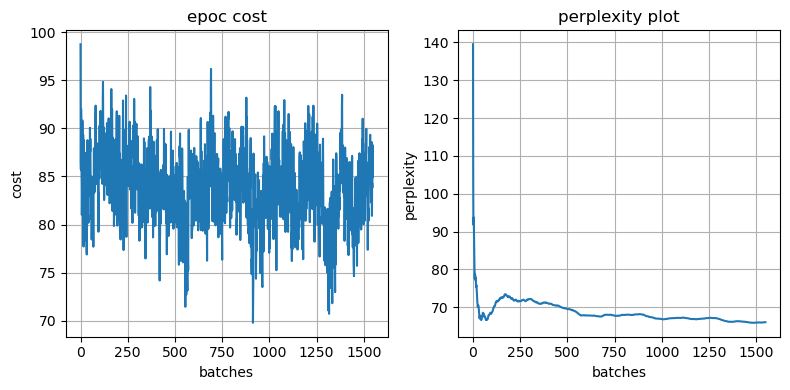

epoc 9 begins
epoc 9 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 128.412353515625
perplexity is 65.01324462890625
perplexity is 62.514461517333984
perplexity is 61.728458404541016
epoc 9 completed
epoc 9 final perplexity is 61.83359909057617


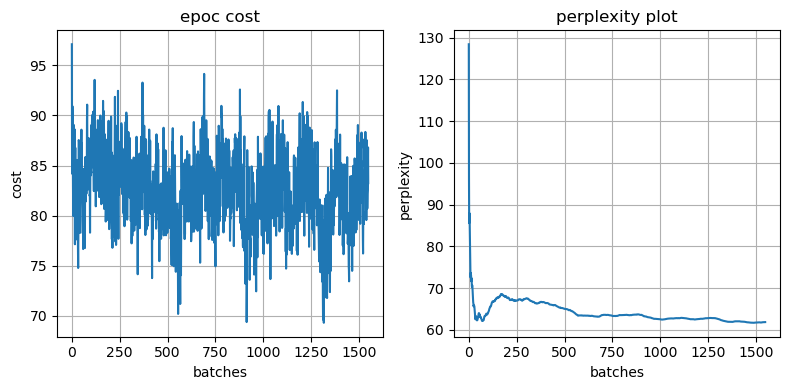

epoc 10 begins
epoc 10 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 122.4000015258789
perplexity is 61.16656494140625
perplexity is 59.00056838989258
perplexity is 58.3165283203125
epoc 10 completed
epoc 10 final perplexity is 58.429256439208984


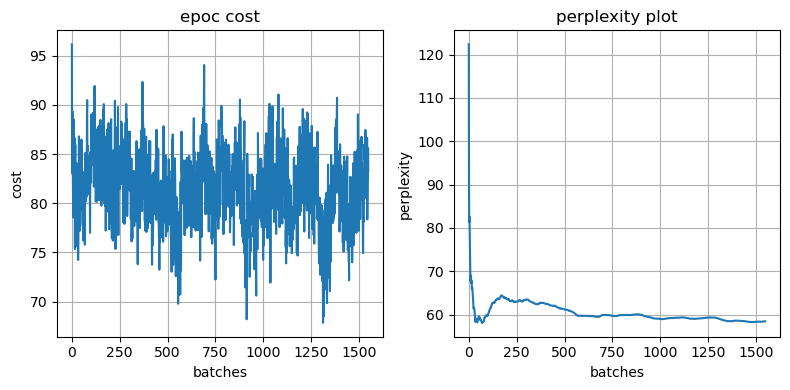

epoc 11 begins
epoc 11 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 110.87824249267578
perplexity is 58.04974365234375
perplexity is 56.04331970214844
perplexity is 55.474609375
epoc 11 completed
epoc 11 final perplexity is 55.58163070678711


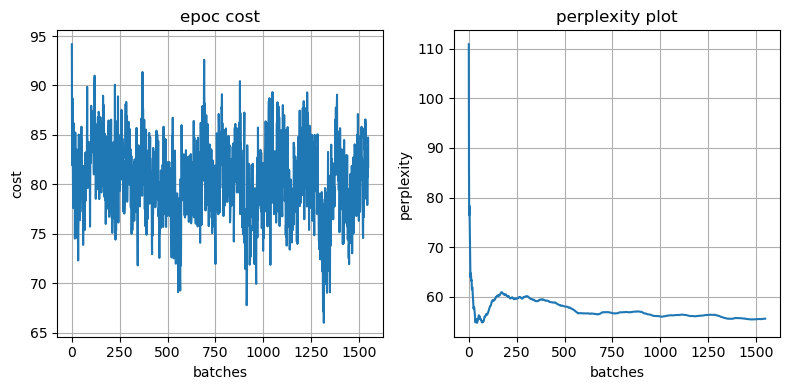

epoc 12 begins
epoc 12 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 104.29003143310547
perplexity is 55.37449645996094
perplexity is 53.493064880371094
perplexity is 52.99953079223633
epoc 12 completed
epoc 12 final perplexity is 53.1070442199707


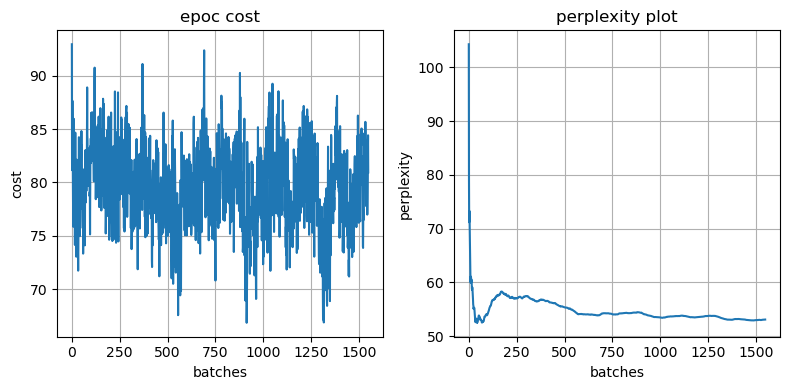

epoc 13 begins
epoc 13 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 107.56413269042969
perplexity is 53.1282958984375
perplexity is 51.42580032348633
perplexity is 50.98588562011719
epoc 13 completed
epoc 13 final perplexity is 51.11702346801758


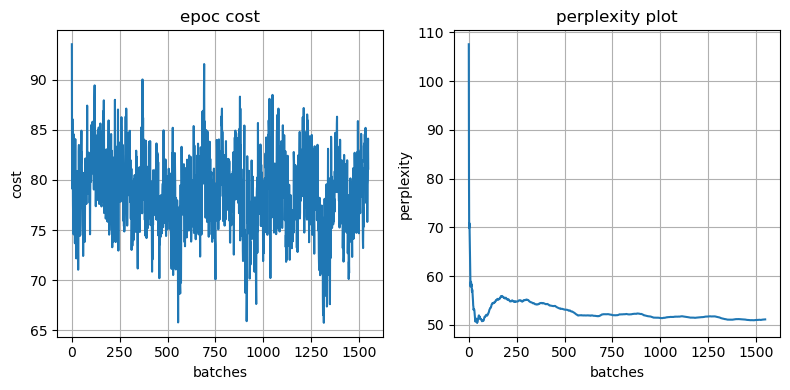

epoc 14 begins
epoc 14 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1.0>
perplexity is 102.76725769042969
perplexity is 51.1633186340332
perplexity is 49.507606506347656
perplexity is 49.043251037597656
epoc 14 completed
epoc 14 final perplexity is 49.151119232177734


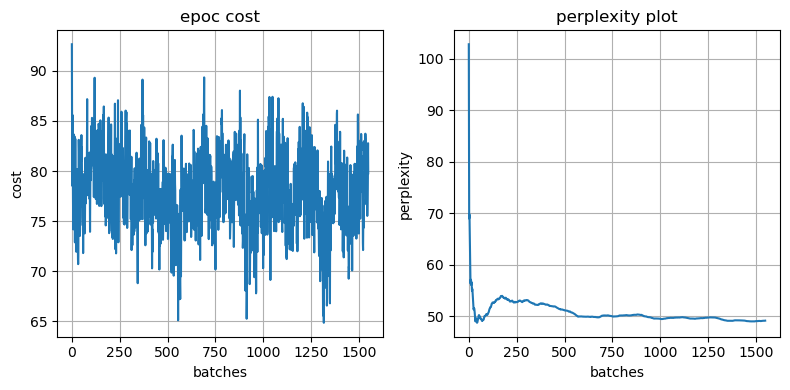

epoc 15 begins
epoc 15 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.5>
perplexity is 98.87776947021484
perplexity is 46.24626922607422
perplexity is 42.55387878417969
perplexity is 40.31223678588867
epoc 15 completed
epoc 15 final perplexity is 40.233299255371094


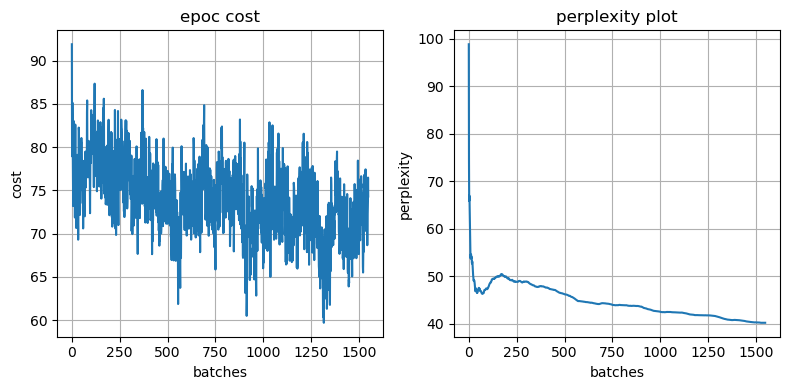

epoc 16 begins
epoc 16 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.25>
perplexity is 80.17750549316406
perplexity is 38.178916931152344
perplexity is 34.918487548828125
perplexity is 32.74776077270508
epoc 16 completed
epoc 16 final perplexity is 32.64480972290039


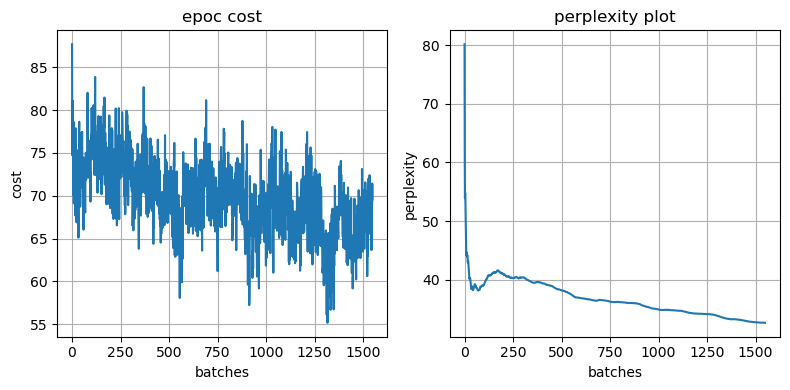

epoc 17 begins
epoc 17 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.125>
perplexity is 70.59130859375
perplexity is 33.45820617675781
perplexity is 30.606369018554688
perplexity is 28.627710342407227
epoc 17 completed
epoc 17 final perplexity is 28.52588653564453


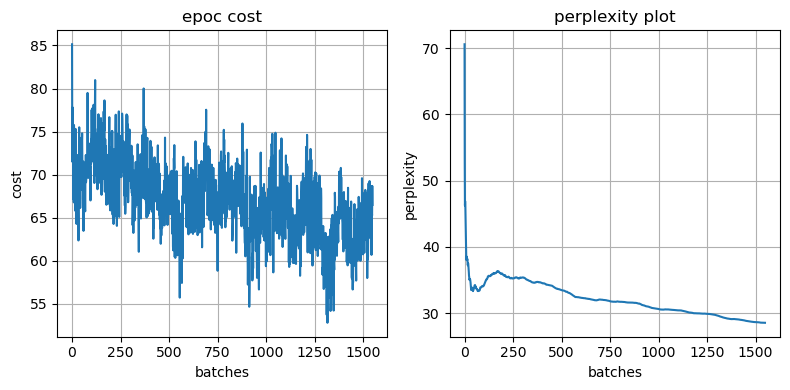

epoc 18 begins
epoc 18 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0625>
perplexity is 66.39542388916016
perplexity is 31.149158477783203
perplexity is 28.519813537597656
perplexity is 26.644563674926758
epoc 18 completed
epoc 18 final perplexity is 26.54583168029785


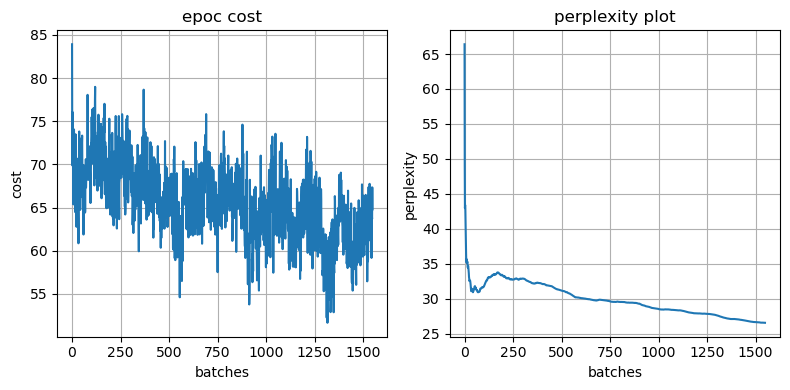

epoc 19 begins
epoc 19 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.03125>
perplexity is 64.009765625
perplexity is 30.0588321685791
perplexity is 27.5521240234375
perplexity is 25.714813232421875
epoc 19 completed
epoc 19 final perplexity is 25.616912841796875


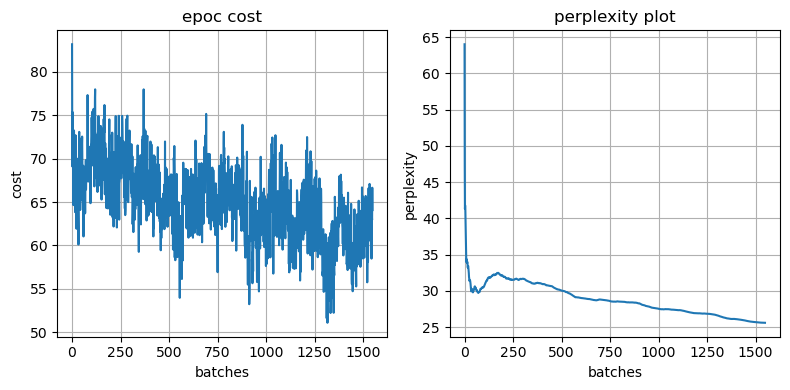

epoc 20 begins
epoc 20 learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.015625>
perplexity is 63.15799331665039
perplexity is 29.506494522094727
perplexity is 27.057741165161133
perplexity is 25.2356014251709
epoc 20 completed
epoc 20 final perplexity is 25.137222290039062


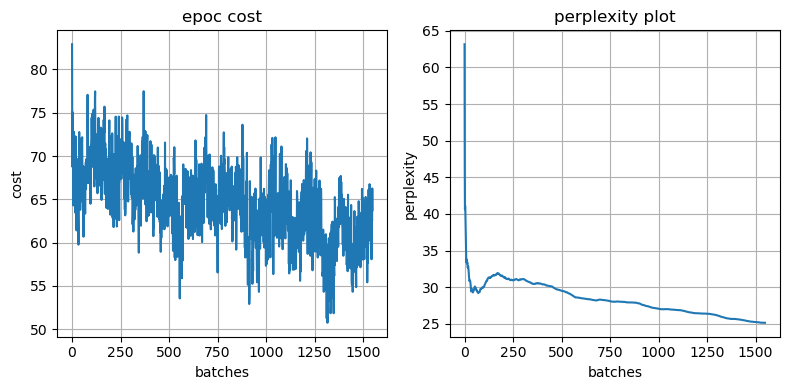

time taken for training is 8.603072495063145 hours


In [37]:
K = tf.keras.backend 
step_size=20
learning_rate=1
max_grad_norm=5
decay=0.5
max_epoch_decay_lr=13
start=time.time()
train(20)
finish=time.time()
total=(finish-start)/(60*60)
print('time taken for training is {} hours'.format(total))
model.save('my_model_3.h5')


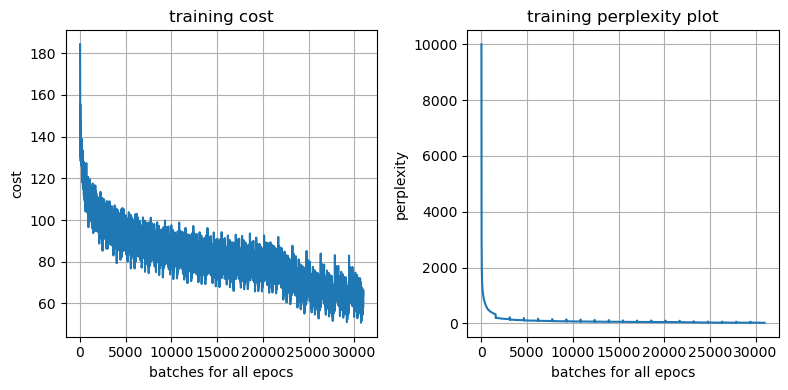

In [38]:
#plot training loss and perplexity
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[ 0].plot(np.array(train_epoc_cost_list))
axes[ 0].set_title('training cost')
axes[ 0].set_xlabel('batches for all epocs')
axes[ 0].set_ylabel('cost')
axes[ 0].grid(True)
        
axes[ 1].plot(np.array(train_perplexity_list))
axes[ 1].set_title('training perplexity plot')
axes[ 1].set_xlabel('batches for all epocs')
axes[ 1].set_ylabel('perplexity')
axes[ 1].grid(True)
            
            
plt.tight_layout()
plt.show()

now lets test our model on testing set

In [81]:
test_epoc_cost_list=[]
test_perplexity_list=[]
couter=0
epoc_cost=0
itter=0
test_itter=loader(test_va_sen_no, 30, 20)
for batch in test_itter:
    x=batch[0]
    y=batch[1]
    
    prob = model(x)
    loss  = crossentropy(y, prob)
    batch_cost= tf.reduce_sum(loss) / batch_size
    test_epoc_cost_list.append(batch_cost)
    
    epoc_cost+=batch_cost
    itter+=20
    #calculate perplexity
    perplexity= np.exp(epoc_cost/itter)
    test_perplexity_list.append(perplexity)
    #print perplexity at every 100 batches
    if couter % 100==0:
        print('perplexity is {}'.format(perplexity))
    couter+=1

perplexity is 230.22023010253906
perplexity is 146.84848022460938


Lets take a look at the output of the model for the first batch 

In [71]:
test_batch=loader(test_va_sen_no, 30, 20)
test_batch=loader(test_va_sen_no, 30, 20)

sample=next(train_itter)
x, y =sample[0], sample[1]
prob=model(x)
yhat=np.argmax(prob[5,0:20], axis=1)
yhat

array([184,  84,  91,   0,  77,  10,  10,  61,  34,  58,   1,   2,   0,
         1,  70,  95, 142, 290,  15,   0], dtype=int64)

In [73]:
np.reshape(id_to_word(word_to_id, x[5]), (1, -1))

array([['to', 'scale', 'back', 'planned', 'high-yield', 'offerings',
        'and', 'several', 'issues', 'have', 'been', 'postponed', '<eos>',
        'william', '<unk>', 'beatrice', 'chief', 'financial', 'officer',
        'said']], dtype='<U10')

In [74]:
np.reshape(id_to_word(word_to_id, yhat), (1, -1))

array([['sell', 'out', 'into', 'the', 'trading', 'that', 'that', 'other',
        'have', 'been', '<unk>', '<eos>', 'the', '<unk>', 'president',
        'co.', 'financial', 'officer', 'said', 'the']], dtype='<U9')

In [75]:
np.reshape(id_to_word(word_to_id, y[5]), (1, -1))

array([['scale', 'back', 'planned', 'high-yield', 'offerings', 'and',
        'several', 'issues', 'have', 'been', 'postponed', '<eos>',
        'william', '<unk>', 'beatrice', 'chief', 'financial', 'officer',
        'said', 'favorable']], dtype='<U10')

## Analysis on the embedding layer of the model

Now that we are done with the training of the model. We can now look at how the embedding layer embedds each word

In [44]:
words=np.array(list(word_to_id.keys()))

In [45]:
ID=np.array(list(word_to_id.values()))

In [46]:
import pandas as pd

In [47]:
# making a data frame of the vocabulary and the word id for each word
df=pd.DataFrame({'words':words, 'ID':ID})
df.head()

,words,ID
0,the,0
1,<unk>,1
2,<eos>,2
3,N,3
4,of,4


In [48]:
x=df['ID'].values
x=np.reshape(x,(1,-1))
x.shape, len(x[0])

((1, 10000), 10000)

Pass the id for each word to produce the emedding for each word

In [49]:
embedding_layer_output = model.layers[0](x)
embedding_layer_output[0].shape

TensorShape([10000, 1000])

In [50]:
#make a data frame from the embedding output. each row corresponds to the embedding for each word
embedd_df=pd.DataFrame(embedding_layer_output[0])

In [51]:
embedd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.145669,-0.244319,0.136822,-0.007181,0.060345,-0.231431,-0.213711,-0.057646,0.077147,-0.063745,...,0.140622,0.105816,0.260717,-0.113073,-0.093822,-0.171142,0.196731,0.055565,-0.027790,0.141050
1,-0.122677,0.069423,0.042287,-0.277549,-0.075160,-0.249161,-0.081546,-0.172375,0.152312,-0.067509,...,0.251138,0.128917,-0.123117,-0.107617,0.047639,-0.082041,-0.090522,-0.043355,0.272153,0.072183
2,0.294060,-0.140436,0.429215,0.129216,0.254373,0.153155,0.083814,0.069831,0.120598,0.213248,...,-0.163335,0.551196,-0.066135,0.096347,0.045841,-0.564270,-0.002561,-0.156198,-0.190321,-0.383801
3,-0.358454,-0.021130,-0.057642,0.036479,-0.094581,-0.133632,-0.039258,0.001244,0.053384,0.232995,...,0.098975,0.180079,0.234050,0.062303,0.250874,-0.097860,0.299690,0.011598,0.002764,0.104765
4,0.032220,-0.219088,-0.052731,-0.044170,0.360552,-0.077353,0.001510,0.017266,0.119827,-0.024001,...,0.197737,-0.050044,0.237630,0.212323,-0.101635,-0.039847,-0.011456,-0.077132,-0.075322,-0.015504


In [52]:
#cancatenate the embedding data frame with the words data frame
word_embedding=pd.concat([df,embedd_df], axis=1 )
word_embedding.head()

,words,ID,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,the,0,0.145669,-0.244319,0.136822,-0.007181,0.060345,-0.231431,-0.213711,-0.057646,...,0.140622,0.105816,0.260717,-0.113073,-0.093822,-0.171142,0.196731,0.055565,-0.027790,0.141050
1,<unk>,1,-0.122677,0.069423,0.042287,-0.277549,-0.075160,-0.249161,-0.081546,-0.172375,...,0.251138,0.128917,-0.123117,-0.107617,0.047639,-0.082041,-0.090522,-0.043355,0.272153,0.072183
2,<eos>,2,0.294060,-0.140436,0.429215,0.129216,0.254373,0.153155,0.083814,0.069831,...,-0.163335,0.551196,-0.066135,0.096347,0.045841,-0.564270,-0.002561,-0.156198,-0.190321,-0.383801
3,N,3,-0.358454,-0.021130,-0.057642,0.036479,-0.094581,-0.133632,-0.039258,0.001244,...,0.098975,0.180079,0.234050,0.062303,0.250874,-0.097860,0.299690,0.011598,0.002764,0.104765
4,of,4,0.032220,-0.219088,-0.052731,-0.044170,0.360552,-0.077353,0.001510,0.017266,...,0.197737,-0.050044,0.237630,0.212323,-0.101635,-0.039847,-0.011456,-0.077132,-0.075322,-0.015504


Reducing the embedding dimention to a 2D array

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
embeds_transform = pca.fit_transform(embedd_df)
embeds_transform

array([[-2.0807152 , -0.42159364],
       [-0.0508663 ,  0.6796398 ],
       [-0.23725942,  1.0046164 ],
       ...,
       [-0.04516134,  0.03621835],
       [-0.14096348,  0.02959366],
       [ 0.18160233,  0.16041523]], dtype=float32)

In [54]:
word_embed_2d=pd.concat([df, pd.DataFrame(embeds_transform)], axis=1)
word_embed_2d.head()

,words,ID,0,1
0,the,0,-2.080715,-0.421594
1,<unk>,1,-0.050866,0.679640
2,<eos>,2,-0.237259,1.004616
3,N,3,0.952278,-0.532488
4,of,4,-0.675579,-1.460952


In [55]:
word_embed_2d.columns=['words', 'ID','x','y']
word_embed_2d.head()

,words,ID,x,y
0,the,0,-2.080715,-0.421594
1,<unk>,1,-0.050866,0.679640
2,<eos>,2,-0.237259,1.004616
3,N,3,0.952278,-0.532488
4,of,4,-0.675579,-1.460952


In [56]:
import altair as alt

### Vizualizing the embedding in a 2D plot

In [57]:
# Plot the 2-dimension embeddings on a chart
chart = alt.Chart(word_embed_2d[:1000]).mark_circle(size=500).encode(
  x=
  alt.X('x',
      scale=alt.Scale(zero=False),
      axis=alt.Axis(labels=False, ticks=False, domain=False)
  ),

  y=
  alt.Y('y',
      scale=alt.Scale(zero=False),
      axis=alt.Axis(labels=False, ticks=False, domain=False)
  ),
  
  tooltip=['words']
  )

text = chart.mark_text(align='left', dx=15, size=12, color='black'
          ).encode(text='words', color= alt.value('black'))

result = (chart + text).configure(background="#FDF7F0"
      ).properties(
      width=1000,
      height=700,
      title="2D Embeddings"
      )

result.interactive()

alt.LayerChart(...)

### vizualizing the clusters in a 2D

Performing clustering analysis on the data embedded word

In [77]:
from sklearn.cluster import KMeans

n_clusters=10

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
classes = kmeans_model.fit_predict(embedd_df)
len(classes), classes.shape

(10000, (10000,))

In [78]:
word_class=pd.concat([word_embed_2d, pd.DataFrame({'classes':classes})], axis=1)
word_class.head()

,words,ID,x,y,classes
0,the,0,-2.080715,-0.421594,0
1,<unk>,1,-0.050866,0.679640,8
2,<eos>,2,-0.237259,1.004616,1
3,N,3,0.952278,-0.532488,3
4,of,4,-0.675579,-1.460952,1


In [79]:
chart = alt.Chart(word_class[:1000]).mark_circle(size=500).encode(
    x=alt.X('x', scale=alt.Scale(zero=False), axis=alt.Axis(labels=False, ticks=False, domain=False)),
    y=alt.Y('y', scale=alt.Scale(zero=False), axis=alt.Axis(labels=False, ticks=False, domain=False)),
    tooltip=['words'],
    color=alt.Color('classes:N', scale=alt.Scale(scheme='category20'))
)

text = chart.mark_text(align='left', dx=15, size=12, color='black').encode(text='words', color=alt.value('black'))

result = (chart + text).configure(background="#FDF7F0").properties(
    width=1000,
    height=700,
    title="2D Embedding cluster Class"
)

result.interactive()


alt.LayerChart(...)